# Chronos-2 Foundation Model Fine-Tuning
This example notebook presents how fine-tuning can be applied to the Chronos-2 model using both built-in Darts features and external libraries.

The following fine-tuning methods will be shown:
1) **Full fine-tuning**: All model weights are retrained. This is natively supported by setting `enable_finetuning=True`.
2) **Partial fine-tuning**: Specific layers are frozen via name patterns. This is natively supported using `freeze_patterns` and `unfreeze_patterns`.
3) **PEFT fine-tuning**: The HuggingFace `peft` library is used via a custom Darts callback (`PeftCallback`) to apply LoRA. This shows how to extend Darts with external specialized libraries.

To be useful, a fine-tuned model should be easily saved and loaded. For each method, we will demonstrate how to persist the model weights.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally

fix_pythonpath_if_working_locally()
%matplotlib inline

In [3]:
import warnings

import numpy as np

from darts.datasets import AirPassengersDataset
from darts.models import Chronos2Model

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

## Data Preparation
Here we just load an example dataset with 144 samples as a fast demo. The data is split between train and validation, with the 2 last years (24 samples) for validation

In [4]:
# convert to float32 as Chronos-2 works with float32 input
data = AirPassengersDataset().load().astype(np.float32)
train_passengers, val_passengers = data.split_before(
    len(data) - 2 * 12
)  # last 2 years for validation

# Model prediction out-of-the-box
Let's see how the model behaves on the validation data without any fine-tuning. For that we:
- Create the model
- Call fit to load the model internally (no training is done)
- Predict on the validation set

Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: title={'center': 'Base model (not finetuned yet)'}, xlabel='Month'>

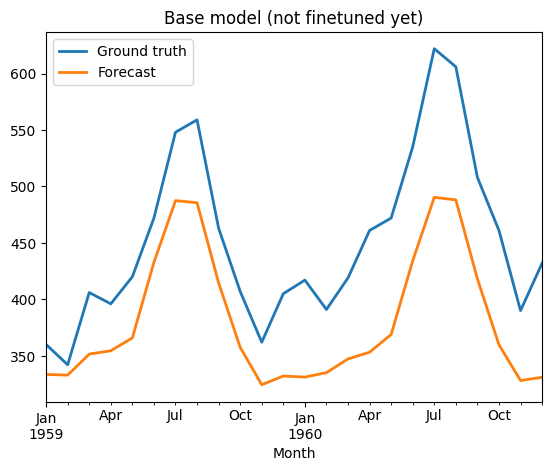

In [5]:
model = Chronos2Model(
    input_chunk_length=24,
    output_chunk_length=6,
)
model.fit(train_passengers, verbose=True)

prediction = model.predict(
    n=len(val_passengers),
    series=train_passengers,
)
val_passengers.plot(label="Ground truth")
prediction.plot(label="Forecast", title="Base model (not finetuned yet)")

# 1. Full fine-tuning

In this method, all the model weights are retrained. This is simply enabled by passing `enable_finetuning=True` to the model constructor. 

When fine-tuning is enabled, Darts will treat the foundation model like a standard trainable model during `fit()`. Saving and loading follows the standard Darts API via the `save()` and `load()` methods.


In [6]:
full_finetuned_model = Chronos2Model(
    input_chunk_length=24,
    output_chunk_length=6,
    enable_finetuning=True,
    n_epochs=100,
    pl_trainer_kwargs={"accelerator": "gpu"},
)
full_finetuned_model.fit(train_passengers, verbose=True)
full_finetuned_model.save("full_finetuned.pt")

# Load
full_finetuned_loaded_model = Chronos2Model.load("full_finetuned.pt")

Training: |          | 0/? [00:00<?, ?it/s]

We can compare the prediction with the ground truth, as well as checking that the loaded model behaves similarly to the fine-tuned model.

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: title={'center': 'Full finetuning'}, xlabel='Month'>

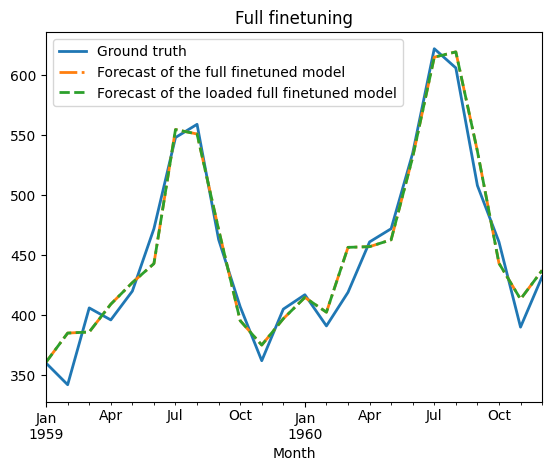

In [7]:
pred_full_finetuned = full_finetuned_model.predict(
    n=len(val_passengers),
    series=train_passengers,
)
pred_full_finetuned_loaded = full_finetuned_loaded_model.predict(
    n=len(val_passengers),
    series=train_passengers,
)
val_passengers.plot(label="Ground truth")
pred_full_finetuned.plot(label="Forecast of the full finetuned model", linestyle="-.")
pred_full_finetuned_loaded.plot(
    label="Forecast of the loaded full finetuned model",
    linestyle="--",
    title="Full finetuning",
)

We can also verify numericaly that the prediction of the trained model is identical to the prediction of the loaded model

In [8]:
np.allclose(pred_full_finetuned.values(), pred_full_finetuned_loaded.values())

True

# 2. Partial fine-tuning with layer freezing

Partial fine-tuning allows you to update only a subset of the model's parameters, which is useful for preserving general knowledge while adapting to specific patterns. 

Darts foundation models natively support this via:
- `freeze_patterns`: A list of parameter name prefixes to freeze (`requires_grad=False`).
- `unfreeze_patterns`: A list of prefixes to unfreeze (applied after freezing).

This mechanism automatically injects a `LayerFreezeCallback` into the training process.

In [9]:
partial_finetuned_model = Chronos2Model(
    input_chunk_length=12,
    output_chunk_length=6,
    enable_finetuning=True,
    freeze_patterns=["encoder.block.0", "encoder.block.1", "encoder.block.2"],
    unfreeze_patterns=["output_patch_embedding"],
    n_epochs=100,
    pl_trainer_kwargs={"accelerator": "gpu"},
)
partial_finetuned_model.fit(train_passengers, verbose=True)
partial_finetuned_model.save("partial_finetuned.pt")

# Load - no callback needed, structure unchanged
partial_finetuned_loaded_model = Chronos2Model.load("partial_finetuned.pt")

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: title={'center': 'Partial finetuning'}, xlabel='Month'>

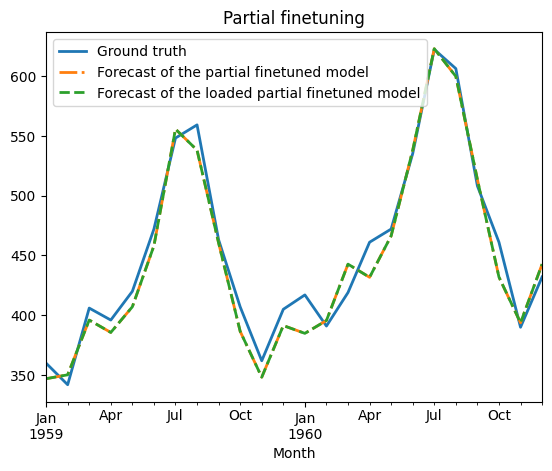

In [10]:
pred_partial_finetuned = partial_finetuned_model.predict(
    n=len(val_passengers),
    series=train_passengers,
    random_state=42,
)
pred_partial_finetuned_loaded = partial_finetuned_loaded_model.predict(
    n=len(val_passengers),
    series=train_passengers,
    random_state=42,
)
val_passengers.plot(label="Ground truth")
pred_partial_finetuned.plot(
    label="Forecast of the partial finetuned model", linestyle="-."
)
pred_partial_finetuned_loaded.plot(
    label="Forecast of the loaded partial finetuned model",
    linestyle="--",
    title="Partial finetuning",
)

Again, we verify that the prediction of the fine-tuned model is the same as the loaded model to make sure that saving/load works correctly

In [11]:
np.allclose(pred_partial_finetuned.values(), pred_partial_finetuned_loaded.values())

True

# 3. LoRA fine-tuning (PEFT)

This method uses the HuggingFace `peft` library for **P**arameter **E**fficient **F**ine-**T**uning. 

Darts provides a `PeftCallback` that wraps the internal model with adapters (like LoRA) before training. One major advantage of this callback is that it automatically handles **weight merging** during checkpointing, allowing the saved model to be loaded back as a standard model without needing the `peft` library at inference time.

More information about peft can be found in the [official documentation](https://github.com/huggingface/peft)

In [22]:
from peft import LoraConfig

from darts.utils.callbacks.fine_tuning import PeftCallback

lora_config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q",
        "v",
        "k",
        "o",
        "output_patch_embedding.output_layer",
    ],
)
peft_callback = PeftCallback(peft_config=lora_config)

model_lora = Chronos2Model(
    input_chunk_length=24,
    output_chunk_length=6,
    enable_finetuning=True,
    n_epochs=100,
    pl_trainer_kwargs={"accelerator": "gpu", "callbacks": [peft_callback]},
)
model_lora.fit(train_passengers, verbose=True)

Training: |          | 0/? [00:00<?, ?it/s]

Chronos2Model(output_chunk_shift=0, likelihood=None, hub_model_name=amazon/chronos-2, hub_model_revision=None, local_dir=None, input_chunk_length=24, output_chunk_length=6, enable_finetuning=True, n_epochs=100, pl_trainer_kwargs={'accelerator': 'gpu', 'callbacks': [<darts.utils.callbacks.fine_tuning.PeftCallback object at 0x000002A87D0F6E10>]})

## 3.1 Full-model saving
Darts `save` and `load` methods can be used to save the full model weights.

In [23]:
# Fully save the model including adapters
model_lora.save("chronos2_lora_finetuned.pt")
model_lora_loaded = Chronos2Model.load("chronos2_lora_finetuned.pt")

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: title={'center': 'LoRA finetuning - Save all'}, xlabel='Month'>

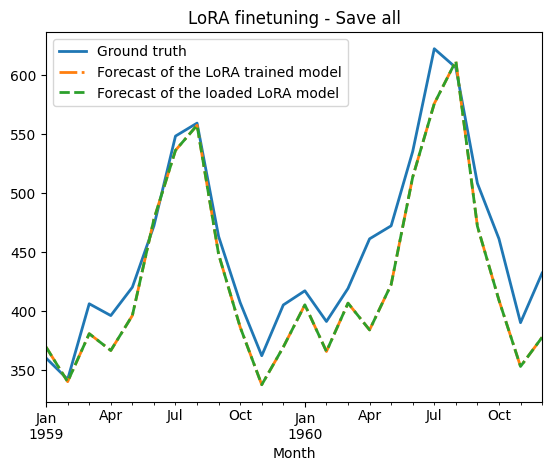

In [24]:
pred_lora_trained = model_lora.predict(
    n=len(val_passengers),
    series=train_passengers,
    random_state=42,
)
pred_lora_loaded = model_lora_loaded.predict(
    n=len(val_passengers),
    series=train_passengers,
    random_state=42,
)
val_passengers.plot(label="Ground truth")
pred_lora_trained.plot(label="Forecast of the LoRA trained model", linestyle="-.")
pred_lora_loaded.plot(
    label="Forecast of the loaded LoRA model",
    linestyle="--",
    title="LoRA finetuning - Save all",
)

Again, we verify that the prediction of the fine-tuned model is the same as the loaded model to make sure that saving/load works correctly

In [25]:
np.allclose(pred_lora_loaded.values(), pred_lora_trained.values())

True

## 3.2 Adapter saving

Alternatively, you may want to save *only* the lightweight adapters rather than the full model weights.

Foundation models in Darts provide an `internal_model` property that gives direct access to the underlying PyTorch `nn.Module`. We can use this to interact with the `peft` API directly for saving and loading.


In [26]:
model_lora.internal_model.save_pretrained("chronos2_lora_adapters/")

Then, a new model can be created, and the internal model can be replaced with the loaded adapter

In [27]:
from peft import PeftModel

model_new = Chronos2Model(
    input_chunk_length=24,
    output_chunk_length=6,
)
model_new.fit(train_passengers)  # Initialize model

# Replace _Chronos2Module with PeftModel containing _Chronos2Module + adapters
model_new.internal_model = PeftModel.from_pretrained(
    model_new.internal_model, "chronos2_lora_adapters/"
)

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: title={'center': 'LoRA finetuning - Save adapters only'}, xlabel='Month'>

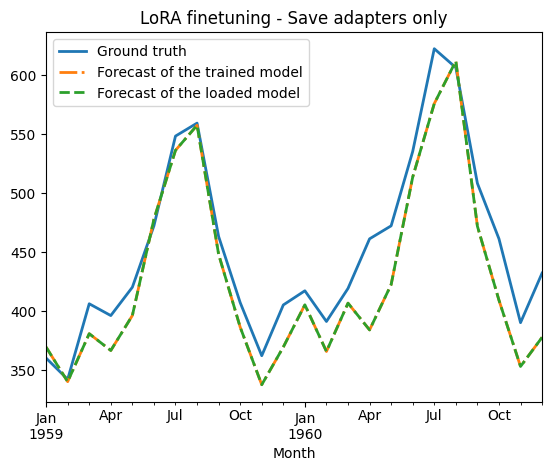

In [28]:
pred_lora_trained = model_lora.predict(
    n=len(val_passengers),
    series=train_passengers,
    random_state=42,
)
pred_new = model_new.predict(
    n=len(val_passengers),
    series=train_passengers,
    random_state=42,
)
val_passengers.plot(label="Ground truth")
pred_lora_trained.plot(label="Forecast of the trained model", linestyle="-.")
pred_new.plot(
    label="Forecast of the loaded model",
    linestyle="--",
    title="LoRA finetuning - Save adapters only",
)

# 4. Performance Evaluation

Finally, let's compare the performance of all four models (Base, Full Fine-tuning, Partial Fine-tuning, and LoRA) on the validation set using standard metrics like **MAPE** (Mean Absolute Percentage Error) and **MAE** (Mean Absolute Error).


In [ ]:
import pandas as pd

from darts.metrics import mae, mape

results = []
all_predictions = {
    "Base Model": prediction,
    "Full Fine-tuning": pred_full_finetuned,
    "Partial Fine-tuning": pred_partial_finetuned,
    "LoRA (PEFT)": pred_lora_trained,
}

for name, pred in all_predictions.items():
    results.append({
        "Model": name,
        "MAPE (%)": mape(val_passengers, pred),
        "MAE": mae(val_passengers, pred),
    })

df_results = pd.DataFrame(results)
df_results

,Model,MAPE (%),MAE
0,Base Model,15.254518,70.704819
1,Full Fine-tuning,3.237262,13.835668
2,Partial Fine-tuning,2.899847,12.568367
3,LoRA (PEFT),5.951829,26.501753


### Observations

While the results on this small "toy" dataset (Air Passengers) may vary depending on the random seed and hyperparameters, they demonstrate the flexibility of the fine-tuning API.

In real-world scenarios with larger datasets:
- **Full Fine-tuning** offers the most flexibility but is computationally expensive and prone to "catastrophic forgetting".
- **Partial Fine-tuning** provides a good middle ground by updating only the most relevant layers (like the output head).
- **LoRA (PEFT)** is often the most effective strategy. It typically matches or exceeds full fine-tuning performance while only training a tiny fraction (often <1%) of the parameters. This makes it faster, more memory-efficient, and allows for much easier deployment of multiple task-specific "adapters" on top of a single base model.

### Summary
In this notebook, we have seen:
1. How to enable **native full fine-tuning** in Darts foundation models.
2. How to use **layer freezing patterns** to perform partial fine-tuning without manual weight manipulation.
3. How to extend Darts foundation models with **custom callbacks** to leverage external libraries like `peft`.
4. How to use the `internal_model` property to gain low-level access to the underlying PyTorch module for advanced operations.
